In [123]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

In [124]:
method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial Parameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure Competency", 
                           "real_early": "Real early Param.",
                           "real_parameters": "Real Param."}


def parameter_table_model(df, latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    rmse_columns = ["method", "sample_size", "rmse_early_A", "rmse_early_delta", "rmse_early_sigma",
                    "rmse_late_A", "rmse_late_delta", "rmse_late_sigma", "rmse_psi"]
    sub_df = sub_df[rmse_columns]
    columns = ["Method","Sample size", "$A^e$", "$\Delta^e$", "$\Sigma^e$",
                       "$A^l$", "$\Delta^l$", "$\Sigma^l$", "$\Psi$"]
    sub_df.columns = columns
    sub_df = sub_df.replace(method_replacement_dict)
    parameter_table = sub_df.groupby(["Sample size", "Method"]).agg(aggfunc)
    parameter_table = np.round(parameter_table, decimals)
    #parameter_table.columns = pd.MultiIndex.from_product([["RMSE"], parameter_table.columns], names=['Metric', ''])
    
    #columns = list(zip(["RMSE" for i in range(0, len(columns))],parameter_table.columns))
    #parameter_table.columns = columns
    print(parameter_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(parameter_table)
    

In [125]:
# Make one combined Model-fit table for all Q-Matrices
def likelihood_table_model(df_list, Q_names=["Full", "Seperated", "Pyramid"], latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3):
    combined_df = pd.DataFrame()
    n=-1
    for i, df in enumerate(df_list):
        q_df_early = df[["early_l_estimated", "method", "sample_size"]]
        q_df_early.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_early.loc[:,"Model"] = "Early"
        q_df_late = df[["late_l_estimated", "method", "sample_size"]]
        q_df_late.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_late.loc[:,"Model"] = "Late"
        q_df = pd.concat((q_df_early, q_df_late), axis=0)
        q_df["Q-type"] = Q_names[i]
        combined_df = pd.concat((combined_df, q_df), axis=0)
    combined_df = combined_df.replace(method_replacement_dict)
    combined_df = np.round(combined_df, 0)
    fit_table = pd.crosstab(index=[combined_df["N"], combined_df["Method"]], 
                            columns=[combined_df["Model"], combined_df["Q-type"]],
                            values=combined_df["Marginal Log-Likelihood"],
                            aggfunc=aggfunc)
    print(fit_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(fit_table)

# TODO: Maybe include empirical likelihood not only marginal?

In [126]:
def single_metric_table(df, metric, aggfunc="median", latex=True, decimals=3, caption=""):
    df = df.replace(method_replacement_dict)
    n = np.min(df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    table = pd.crosstab(index=[df["sample_size"], df["method"]],
                columns=[df["latent_dimension"], df["item_dimension"]], 
                values=df[metric], 
                aggfunc=aggfunc)
    table = np.round(table, decimals)
    if latex:
        print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,
                             caption=caption+", n={0}".format(n),
                             position="H"))
    return(table)

In [127]:
def model_boxplot(df, metric='rmse_psi', latent_dimension=2, item_dimension=20, 
                  title="",
                  methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[(sub_df["method"].isin(methods))]
    sub_df = sub_df.replace(method_replacement_dict)
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    fig = plt.gcf()
    fig.set_dpi(100)
    fig.set_size_inches(10, 5)
    plt.title(title+", n={0}".format(n))
    sn.boxplot(x=sub_df[metric], hue=sub_df["sample_size"].astype("str"), y=sub_df["method"],
               orient="h")

# Results

In [128]:
full_Q_df = pd.read_csv("results/full_q.csv")
print("Full Q sample size: {0}".format(full_Q_df.shape[0]))
sep_Q_df = pd.read_csv("results/seperated_q.csv")
print("Seperated Q sample size: {0}".format(sep_Q_df.shape[0]))
pyramid_Q_df = pd.read_csv("results/pyramid_q.csv")
print("Pyramid Q sample size: {0}".format(pyramid_Q_df.shape[0]))

Full Q sample size: 540
Seperated Q sample size: 602
Pyramid Q sample size: 590


## Simulatuion Results

### Model Fit

In [129]:
single_metric_table(full_Q_df, metric="late_l_estimated")

\begin{table}[H]
\centering
\caption{, n=6}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &        10 &        20 &       10 &        20 \\
\textbf{sample\_size} & \textbf{method} &           &           &          &           \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  -162.310 &  -249.235 &  -203.97 &  -289.595 \\
    & \textbf{Initial Parameters} &  -206.600 &  -371.835 &  -273.95 &  -440.630 \\
    & \textbf{Late EM} &  -169.160 &  -257.945 &  -194.53 &  -277.905 \\
    & \textbf{Pure Competency} &  -166.360 &  -247.030 &  -201.56 &  -289.645 \\
    & \textbf{Real Param.} &  -181.350 &  -290.560 &  -220.84 &  -313.780 \\
    & \textbf{Real early Param.} &  -185.250 &  -259.365 &  -214.32 &  -284.610 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  -570.240 &  -940.230 &  -729.24 & -1010.700 \\
    & \textbf{Initial Parameters} &  -726.580

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                       2                  3          
item_dimension                        10        20       10        20
sample_size method                                                   
30          Difference          -162.310  -249.235  -203.97  -289.595
            Initial Parameters  -206.600  -371.835  -273.95  -440.630
            Late EM             -169.160  -257.945  -194.53  -277.905
            Pure Competency     -166.360  -247.030  -201.56  -289.645
            Real Param.         -181.350  -290.560  -220.84  -313.780
            Real early Param.   -185.250  -259.365  -214.32  -284.610
100         Difference          -570.240  -940.230  -729.24 -1010.700
            Initial Parameters  -726.580 -1205.250  -955.81 -1452.720
            Late EM             -565.980  -894.870  -683.75  -969.030
            Pure Competency     -571.885  -911.560  -715.32  -979.260
            Real Param.         -592.445  -954.200  -729.25 -1041.530
            Real early Param.   -602.315  -905.540  -746.62 -1020.500
200         Difference         -1253.790 -1845.100 -1440.27 -2153.585
            Initial Parameters -1519.480 -2416.840 -1879.76 -2957.540
            Late EM            -1209.260 -1808.480 -1349.40 -2036.830
            Pure Competency    -1238.680 -1827.680 -1426.48 -2070.035
            Real Param.        -1258.050 -1862.910 -1488.47 -2077.560
            Real early Param.  -1285.230 -1852.210 -1541.49 -2144.570

In [130]:
likelihood_table_model(df_list=[full_Q_df, sep_Q_df, pyramid_Q_df])

\begin{table}[H]
\centering
\caption{, n=-1}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Model} & \multicolumn{3}{l}{Early} & \multicolumn{3}{l}{Late} \\
    & \textbf{Q-type} &    Full & Pyramid & Seperated &    Full & Pyramid & Seperated \\
\textbf{N} & \textbf{Method} &         &         &           &         &         &           \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  -160.0 &  -155.5 &    -222.5 &  -217.5 &  -197.0 &    -269.5 \\
    & \textbf{Initial Parameters} &  -171.0 &  -166.0 &    -238.0 &  -295.0 &  -273.5 &    -358.0 \\
    & \textbf{Late EM} &  -159.5 &  -155.5 &    -221.5 &  -220.5 &  -182.0 &    -242.5 \\
    & \textbf{Pure Competency} &  -162.0 &     NaN &    -164.0 &  -220.5 &     NaN &    -216.0 \\
    & \textbf{Real Param.} &     NaN &     NaN &       NaN &  -243.0 &  -221.5 &    -267.0 \\
    & \textbf{Real early Param.} &     NaN &     NaN &       NaN &  -224.0 &  -199.5 &    -254.0 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1890911269.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fit_table.to_latex(bold_rows=True, multirow=True,


Model                    Early                      Late                  
Q-type                    Full Pyramid Seperated    Full Pyramid Seperated
N   Method                                                                
30  Difference          -160.0  -155.5    -222.5  -217.5  -197.0    -269.5
    Initial Parameters  -171.0  -166.0    -238.0  -295.0  -273.5    -358.0
    Late EM             -159.5  -155.5    -221.5  -220.5  -182.0    -242.5
    Pure Competency     -162.0     NaN    -164.0  -220.5     NaN    -216.0
    Real Param.            NaN     NaN       NaN  -243.0  -221.5    -267.0
    Real early Param.      NaN     NaN       NaN  -224.0  -199.5    -254.0
100 Difference          -566.0  -626.5    -743.5  -741.0  -734.0    -865.5
    Initial Parameters  -582.0  -688.5    -812.0 -1010.0  -986.0   -1181.0
    Late EM             -567.0  -629.0    -743.0  -695.0  -695.0    -814.0
    Pure Competency     -565.0     NaN   -1055.0  -744.0     NaN   -1002.0
    Real Param.            NaN     NaN       NaN  -775.0  -774.0    -865.0
    Real early Param.      NaN     NaN       NaN  -778.0  -760.5    -896.0
200 Difference         -1115.0 -1290.5   -1511.0 -1604.0 -1378.5   -1740.5
    Initial Parameters -1196.0 -1401.5   -1627.5 -2141.0 -1844.5   -2423.0
    Late EM            -1118.0 -1290.5   -1511.0 -1532.0 -1306.0   -1679.0
    Pure Competency    -1122.0     NaN       NaN -1525.0     NaN       NaN
    Real Param.            NaN     NaN       NaN -1613.0 -1448.0   -1772.0
    Real early Param.      NaN     NaN       NaN -1775.0 -1513.0   -1805.0

### Full Q Matrix

In [131]:
parameter_table_model(full_Q_df, caption="Full Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Reference Model, n=7}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &   $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &         &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  2.417 &       2.116 &       0.053 &   4.766 &       3.931 &       0.217 &   0.261 \\
    & \textbf{Initial Parameters} &  1.159 &       0.605 &       0.176 &   1.293 &       1.495 &       0.535 &   0.389 \\
    & \textbf{Late EM} &  2.488 &       1.827 &       0.059 &  14.065 &       7.134 &       0.209 &   0.327 \\
    & \textbf{Pure Competency} &  2.191 &       1.949 &       0.178 &  10.504 &       6.296 &       0.229 &   0.310 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &   0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} & 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$   $A^l$  \
Sample size Method                                                      
30          Difference          2.417       2.116       0.053   4.766   
            Initial Parameters  1.159       0.605       0.176   1.293   
            Late EM             2.488       1.827       0.059  14.065   
            Pure Competency     2.191       1.949       0.178  10.504   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   9.826   
100         Difference          0.707       0.459       0.053   0.970   
            Initial Parameters  1.396       0.540       0.100   1.407   
            Late EM             0.642       0.468       0.056   1.252   
            Pure Competency     0.598       0.442       0.325   1.609   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   1.118   
200         Difference          0.517       0.348       0.089   0.492   
            Initial Parameters  1.355       0.548       0.131   1.369   
            Late EM             0.473       0.362       0.094   0.576   
            Pure Competency     0.496       0.329       0.223   0.510   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   0.441   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               3.931       0.217   0.261  
            Initial Parameters       1.495       0.535   0.389  
            Late EM                  7.134       0.209   0.327  
            Pure Competency          6.296       0.229   0.310  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        4.913       0.173   0.325  
100         Difference               0.799       0.130   0.182  
            Initial Parameters       1.682       0.368   0.214  
            Late EM                  1.009       0.257   0.216  
            Pure Competency          1.601       0.339   0.200  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.963       0.247   0.213  
200         Difference               0.634       0.090   0.199  
            Initial Parameters       1.424       0.374   0.338  
            Late EM                  0.693       0.242   0.288  
            Pure Competency          0.614       0.361   0.299  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.624       0.244   0.310

In [132]:
single_metric_table(full_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=6}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.328 &  0.261 &  0.311 &  0.288 \\
    & \textbf{Initial Parameters} &  0.308 &  0.389 &  0.297 &  0.327 \\
    & \textbf{Late EM} &  0.277 &  0.327 &  0.285 &  0.346 \\
    & \textbf{Pure Competency} &  0.255 &  0.310 &  0.278 &  0.302 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.303 &  0.325 &  0.277 &  0.352 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.327 &  0.182 &  0.242 &  0.218 \\
    & \textbf{Initial Parameters} &  0.388 &  0.214 &  0.288 &  0.291 \\
    & \textbf{Late EM} &  0.399 &  0.216 & 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.328  0.261  0.311  0.288
            Initial Parameters  0.308  0.389  0.297  0.327
            Late EM             0.277  0.327  0.285  0.346
            Pure Competency     0.255  0.310  0.278  0.302
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.303  0.325  0.277  0.352
100         Difference          0.327  0.182  0.242  0.218
            Initial Parameters  0.388  0.214  0.288  0.291
            Late EM             0.399  0.216  0.311  0.317
            Pure Competency     0.312  0.200  0.244  0.278
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.388  0.213  0.291  0.327
200         Difference          0.245  0.199  0.313  0.239
            Initial Parameters  0.350  0.338  0.349  0.367
            Late EM             0.316  0.288  0.358  0.402
            Pure Competency     0.209  0.299  0.298  0.321
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.424  0.310  0.384  0.407

In [133]:
single_metric_table(full_Q_df, "rmse_late_sigma", caption="RMSE for Correlations late sigma")

\begin{table}[H]
\centering
\caption{RMSE for Correlations late sigma, n=6}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.264 &  0.217 &  0.216 &  0.221 \\
    & \textbf{Initial Parameters} &  0.450 &  0.535 &  0.371 &  0.402 \\
    & \textbf{Late EM} &  0.298 &  0.209 &  0.309 &  0.362 \\
    & \textbf{Pure Competency} &  0.189 &  0.229 &  0.350 &  0.357 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.264 &  0.173 &  0.283 &  0.354 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.150 &  0.130 &  0.155 &  0.166 \\
    & \textbf{Initial Parameters} &  0.372 &  0.368 &  0.361 &  0.358 \\
    & \textbf{Late EM} &  0.212 &  0.25

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.264  0.217  0.216  0.221
            Initial Parameters  0.450  0.535  0.371  0.402
            Late EM             0.298  0.209  0.309  0.362
            Pure Competency     0.189  0.229  0.350  0.357
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.264  0.173  0.283  0.354
100         Difference          0.150  0.130  0.155  0.166
            Initial Parameters  0.372  0.368  0.361  0.358
            Late EM             0.212  0.257  0.250  0.310
            Pure Competency     0.219  0.339  0.289  0.227
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.129  0.247  0.188  0.302
200         Difference          0.105  0.090  0.214  0.164
            Initial Parameters  0.404  0.374  0.403  0.362
            Late EM             0.248  0.242  0.301  0.260
            Pure Competency     0.260  0.361  0.352  0.291
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.181  0.244  0.242  0.233

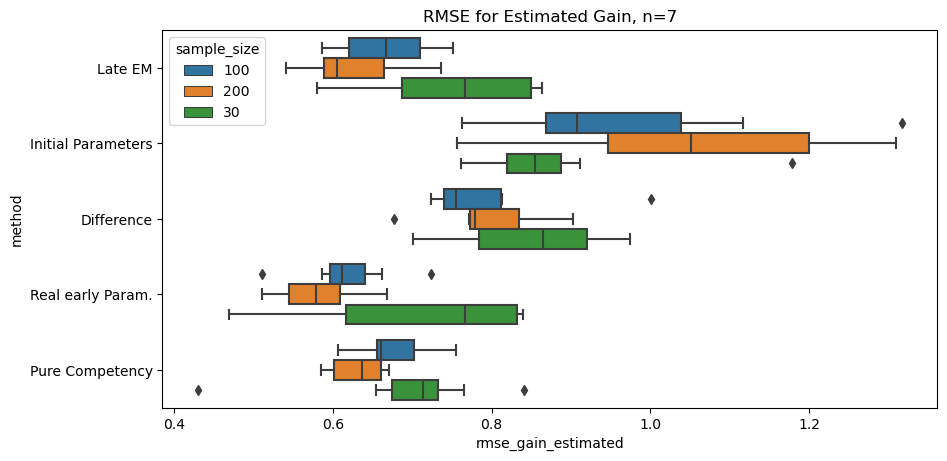

In [134]:
model_boxplot(full_Q_df, metric='rmse_gain_estimated', title="RMSE for Estimated Gain")

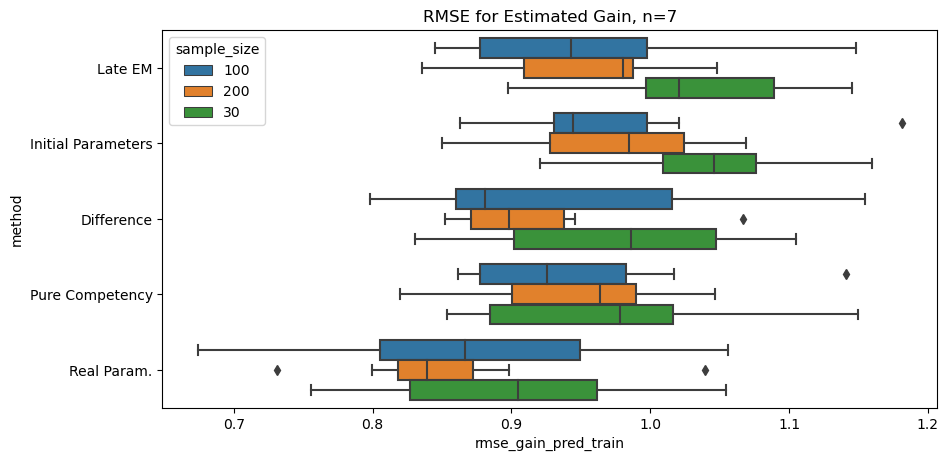

In [135]:
model_boxplot(full_Q_df, metric='rmse_gain_pred_train', title="RMSE for Estimated Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency"])

### Seperated Q-Matrix

In [12]:
parameter_table_model(sep_Q_df, caption="Seperated Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix, Reference Model, n=1}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  1.472 &       1.007 &       0.103 &  3.306 &       2.364 &       0.222 &   0.284 \\
    & \textbf{Initial Parameters} &  1.052 &       0.557 &       0.132 &  1.217 &       1.472 &       0.424 &   0.404 \\
    & \textbf{Late EM} &  1.739 &       1.036 &       0.113 &  4.849 &       3.325 &       0.188 &   0.325 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &  0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  4.569 &       3.677 &       0.176 &   0.351 \\
\cline{1-9}
\multirow{6}{*}{\textbf

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.472       1.007       0.103  3.306   
            Initial Parameters  1.052       0.557       0.132  1.217   
            Late EM             1.739       1.036       0.113  4.849   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  4.569   
100         Difference          0.454       0.387       0.039  0.569   
            Initial Parameters  1.076       0.534       0.099  1.289   
            Late EM             0.523       0.412       0.043  0.872   
            Pure Competency     0.319       0.241       0.422  1.491   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  0.956   
200         Difference          0.326       0.310       0.035  0.441   
            Initial Parameters  1.072       0.425       0.148  1.535   
            Late EM             0.337       0.299       0.030  0.792   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  0.610   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.364       0.222   0.284  
            Initial Parameters       1.472       0.424   0.404  
            Late EM                  3.325       0.188   0.325  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        3.677       0.176   0.351  
100         Difference               0.816       0.106   0.214  
            Initial Parameters       1.390       0.467   0.342  
            Late EM                  0.782       0.190   0.446  
            Pure Competency          0.545       0.267   0.219  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.776       0.201   0.428  
200         Difference               0.438       0.107   0.211  
            Initial Parameters       1.495       0.357   0.323  
            Late EM                  1.260       0.208   0.481  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.874       0.207   0.511

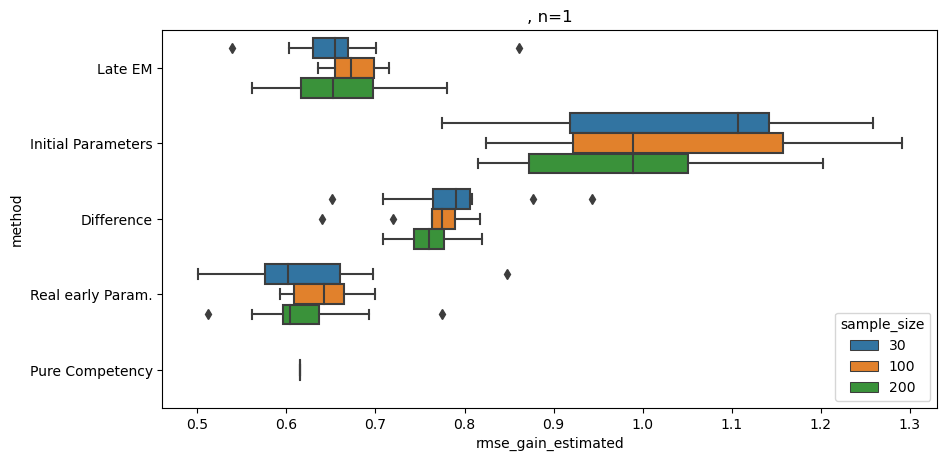

In [13]:
model_boxplot(sep_Q_df, metric='rmse_gain_estimated')

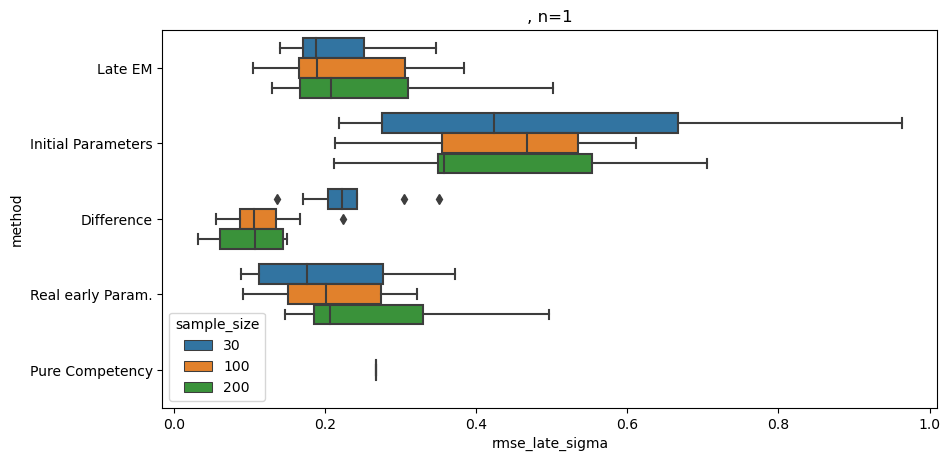

In [14]:
model_boxplot(sep_Q_df, metric='rmse_late_sigma')

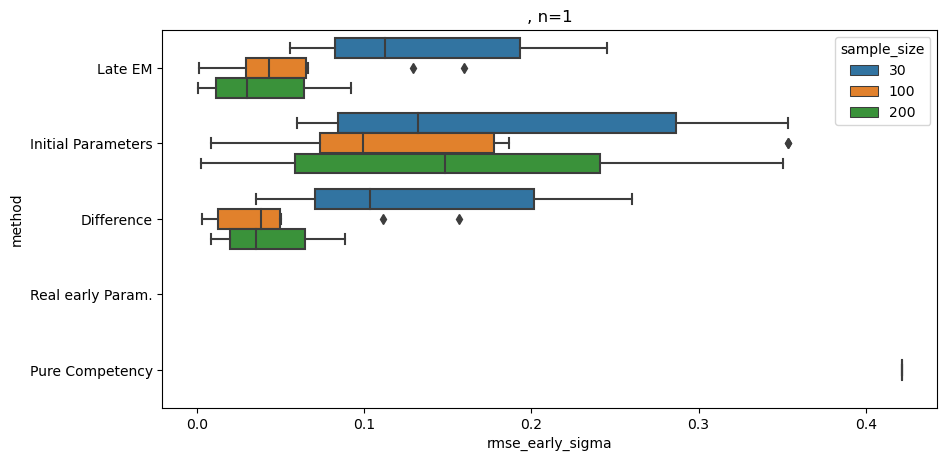

In [15]:
model_boxplot(sep_Q_df, metric='rmse_early_sigma')

### Pyramid Q-Matrix

In [16]:
parameter_table_model(full_Q_df, caption="Pyramid-Q-Matrix, RMSE Median of Parameter Recovery")

\begin{table}[H]
\centering
\caption{Pyramid-Q-Matrix, RMSE Median of Parameter Recovery, n=2}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &   $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &         &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  1.725 &       1.398 &       0.108 &  11.937 &       6.337 &       0.203 &   0.378 \\
    & \textbf{Initial Parameters} &  1.090 &       0.632 &       0.293 &   1.198 &       1.575 &       0.592 &   0.451 \\
    & \textbf{Late EM} &  2.122 &       1.630 &       0.118 &  22.446 &      10.105 &       0.130 &   0.381 \\
    & \textbf{Pure Competency} &  1.818 &       1.206 &       0.060 &  11.135 &       7.087 &       0.177 &   0.302 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &   0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$   $A^l$  \
Sample size Method                                                      
30          Difference          1.725       1.398       0.108  11.937   
            Initial Parameters  1.090       0.632       0.293   1.198   
            Late EM             2.122       1.630       0.118  22.446   
            Pure Competency     1.818       1.206       0.060  11.135   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN  12.580   
100         Difference          0.536       0.458       0.021   0.970   
            Initial Parameters  1.217       0.523       0.105   1.550   
            Late EM             0.520       0.417       0.019   1.312   
            Pure Competency     0.528       0.442       0.454   1.673   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   1.428   
200         Difference          0.464       0.317       0.085   0.421   
            Initial Parameters  1.133       0.573       0.205   1.321   
            Late EM             0.396       0.322       0.088   0.732   
            Pure Competency     0.376       0.316       0.205   0.398   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   0.388   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               6.337       0.203   0.378  
            Initial Parameters       1.575       0.592   0.451  
            Late EM                 10.105       0.130   0.381  
            Pure Competency          7.087       0.177   0.302  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        5.585       0.147   0.453  
100         Difference               0.768       0.220   0.198  
            Initial Parameters       1.677       0.419   0.202  
            Late EM                  1.009       0.228   0.189  
            Pure Competency          2.187       0.415   0.168  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.915       0.247   0.209  
200         Difference               0.659       0.082   0.285  
            Initial Parameters       1.569       0.325   0.378  
            Late EM                  1.068       0.364   0.367  
            Pure Competency          0.751       0.267   0.338  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.811       0.312   0.422

In [17]:
single_metric_table(pyramid_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=8}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.281 &  0.261 &  0.295 &  0.280 \\
    & \textbf{Initial Parameters} &  0.335 &  0.369 &  0.291 &  0.317 \\
    & \textbf{Late EM} &  0.291 &  0.376 &  0.250 &  0.292 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.276 &  0.321 &  0.302 &  0.316 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.230 &  0.307 &  0.323 &  0.283 \\
    & \textbf{Initial Parameters} &  0.283 &  0.308 &  0.339 &  0.355 \\
    & \textbf{Late EM} &  0.234 &  0.381 &  0.344 &  0.318 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.0

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.281  0.261  0.295  0.280
            Initial Parameters  0.335  0.369  0.291  0.317
            Late EM             0.291  0.376  0.250  0.292
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.276  0.321  0.302  0.316
100         Difference          0.230  0.307  0.323  0.283
            Initial Parameters  0.283  0.308  0.339  0.355
            Late EM             0.234  0.381  0.344  0.318
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.234  0.384  0.394  0.347
200         Difference          0.289  0.230  0.316  0.284
            Initial Parameters  0.314  0.273  0.298  0.292
            Late EM             0.432  0.448  0.363  0.450
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.480  0.562  0.428  0.493

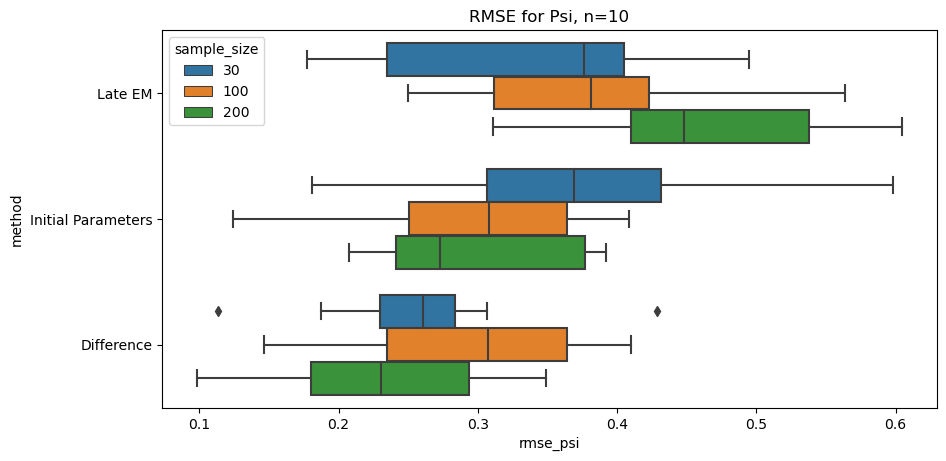

In [18]:
model_boxplot(pyramid_Q_df, metric="rmse_psi", methods=["late_em", "initial", "difference"], title="RMSE for Psi")

## Experiment 2: Prediction of Competency Gain

In [20]:
single_metric_table(full_Q_df, "rmse_theta", caption="Median RMSE for the estimation of $\\theta$")

\begin{table}[H]
\centering
\caption{Median RMSE for the estimation of $\theta$, n=2}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.602 &  0.466 &  0.645 &  0.573 \\
    & \textbf{Initial Parameters} &  0.584 &  0.501 &  0.643 &  0.544 \\
    & \textbf{Late EM} &  0.596 &  0.470 &  0.653 &  0.573 \\
    & \textbf{Pure Competency} &  0.618 &  0.451 &  0.669 &  0.592 \\
    & \textbf{Real Param.} &  0.516 &  0.430 &  0.583 &  0.463 \\
    & \textbf{Real early Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.535 &  0.447 &  0.601 &  0.474 \\
    & \textbf{Initial Parameters} &  0.560 &  0.482 &  0.620 &  0.542 \\
    & \textbf{Late EM} &  0.5

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.602  0.466  0.645  0.573
            Initial Parameters  0.584  0.501  0.643  0.544
            Late EM             0.596  0.470  0.653  0.573
            Pure Competency     0.618  0.451  0.669  0.592
            Real Param.         0.516  0.430  0.583  0.463
            Real early Param.   0.000  0.000  0.000  0.000
100         Difference          0.535  0.447  0.601  0.474
            Initial Parameters  0.560  0.482  0.620  0.542
            Late EM             0.541  0.438  0.595  0.476
            Pure Competency     0.546  0.446  0.612  0.488
            Real Param.         0.533  0.414  0.572  0.471
            Real early Param.   0.000  0.000  0.000  0.000
200         Difference          0.511  0.452  0.659  0.500
            Initial Parameters  0.558  0.528  0.698  0.579
            Late EM             0.510  0.454  0.661  0.507
            Pure Competency     0.513  0.468  0.646  0.517
            Real Param.         0.509  0.451  0.635  0.503
            Real early Param.   0.000  0.000  0.000  0.000

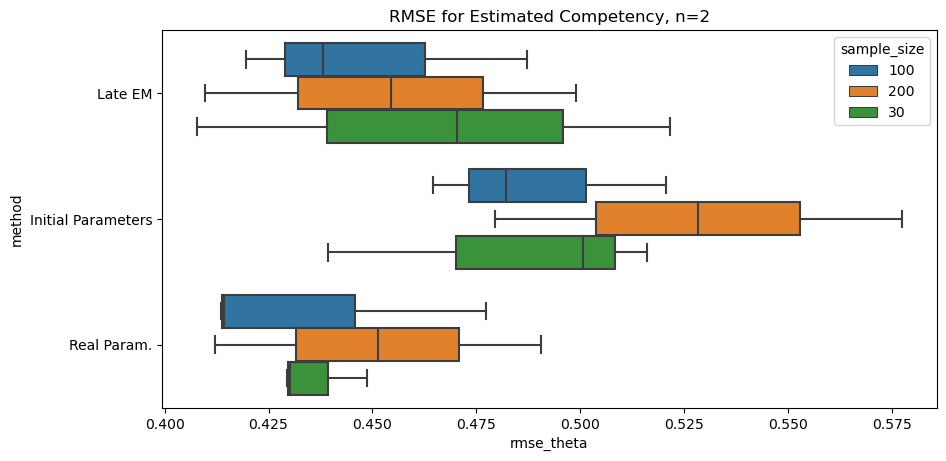

In [21]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial", "real_parameters"], title="RMSE for Estimated Competency")
plt.savefig("results/plots/boxplot_full_Q_rmse_theta.png", bbox_inches="tight")

In [22]:
single_metric_table(full_Q_df, "rmse_gain_estimated", caption="Median RMSE for Competency Gain Estimation")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Estimation, n=2}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.853 &  0.880 &  0.849 &  0.821 \\
    & \textbf{Initial Parameters} &  0.877 &  0.880 &  0.994 &  1.003 \\
    & \textbf{Late EM} &  0.808 &  0.809 &  0.843 &  0.824 \\
    & \textbf{Pure Competency} &  0.761 &  0.721 &  0.832 &  0.777 \\
    & \textbf{Real Param.} &  0.641 &  0.615 &  0.602 &  0.504 \\
    & \textbf{Real early Param.} &  0.758 &  0.835 &  0.828 &  0.777 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.892 &  0.809 &  0.862 &  0.888 \\
    & \textbf{Initial Parameters} &  0.839 &  0.895 &  0.942 &  0.883 \\
    & \textbf{Late EM} &  0.7

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.853  0.880  0.849  0.821
            Initial Parameters  0.877  0.880  0.994  1.003
            Late EM             0.808  0.809  0.843  0.824
            Pure Competency     0.761  0.721  0.832  0.777
            Real Param.         0.641  0.615  0.602  0.504
            Real early Param.   0.758  0.835  0.828  0.777
100         Difference          0.892  0.809  0.862  0.888
            Initial Parameters  0.839  0.895  0.942  0.883
            Late EM             0.764  0.623  0.797  0.735
            Pure Competency     0.704  0.659  0.771  0.689
            Real Param.         0.555  0.576  0.571  0.517
            Real early Param.   0.776  0.612  0.739  0.720
200         Difference          0.789  0.775  0.917  0.917
            Initial Parameters  0.935  1.014  1.025  1.028
            Late EM             0.719  0.655  0.841  0.690
            Pure Competency     0.680  0.620  0.802  0.735
            Real Param.         0.551  0.473  0.581  0.514
            Real early Param.   0.677  0.617  0.782  0.665

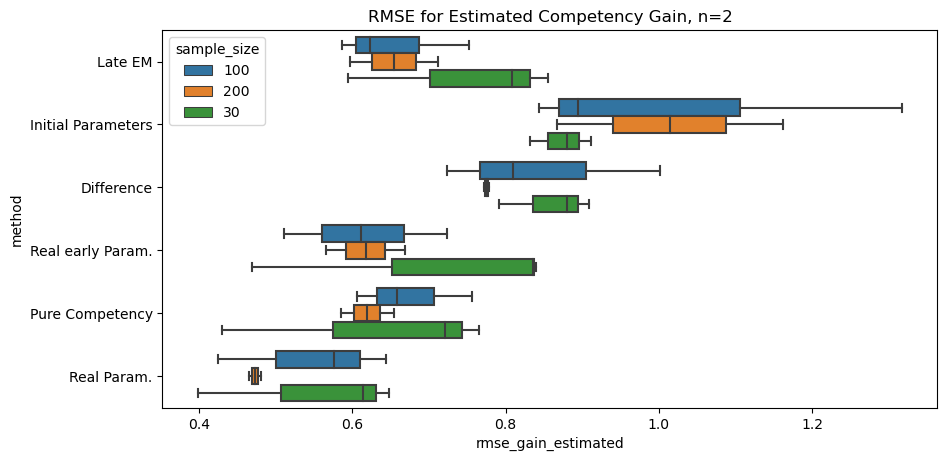

In [23]:
model_boxplot(full_Q_df, metric="rmse_gain_estimated", title="RMSE for Estimated Competency Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_estimated.png", bbox_inches="tight")

In [24]:
single_metric_table(full_Q_df, "rmse_gain_pred_train", caption="Median RMSE for Competency Gain Prediction")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Prediction, n=2}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.878 &  0.970 &  1.005 &  0.949 \\
    & \textbf{Initial Parameters} &  0.907 &  1.003 &  0.971 &  1.017 \\
    & \textbf{Late EM} &  0.926 &  0.970 &  0.997 &  1.021 \\
    & \textbf{Pure Competency} &  0.916 &  0.889 &  0.973 &  1.012 \\
    & \textbf{Real Param.} &  0.783 &  0.837 &  0.806 &  0.861 \\
    & \textbf{Real early Param.} &  0.907 &  1.036 &  0.993 &  0.998 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.943 &  1.069 &  0.991 &  0.916 \\
    & \textbf{Initial Parameters} &  0.954 &  1.021 &  0.996 &  1.006 \\
    & \textbf{Late EM} &  1.0

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.878  0.970  1.005  0.949
            Initial Parameters  0.907  1.003  0.971  1.017
            Late EM             0.926  0.970  0.997  1.021
            Pure Competency     0.916  0.889  0.973  1.012
            Real Param.         0.783  0.837  0.806  0.861
            Real early Param.   0.907  1.036  0.993  0.998
100         Difference          0.943  1.069  0.991  0.916
            Initial Parameters  0.954  1.021  0.996  1.006
            Late EM             1.041  1.028  0.982  1.054
            Pure Competency     0.934  1.017  0.980  1.005
            Real Param.         0.780  0.971  0.899  0.789
            Real early Param.   1.042  1.053  0.968  1.052
200         Difference          0.900  0.871  1.071  1.023
            Initial Parameters  0.969  0.930  1.097  1.054
            Late EM             0.973  0.909  1.066  1.047
            Pure Competency     0.890  0.902  1.082  1.036
            Real Param.         0.817  0.784  0.915  0.935
            Real early Param.   0.974  0.956  1.066  1.046

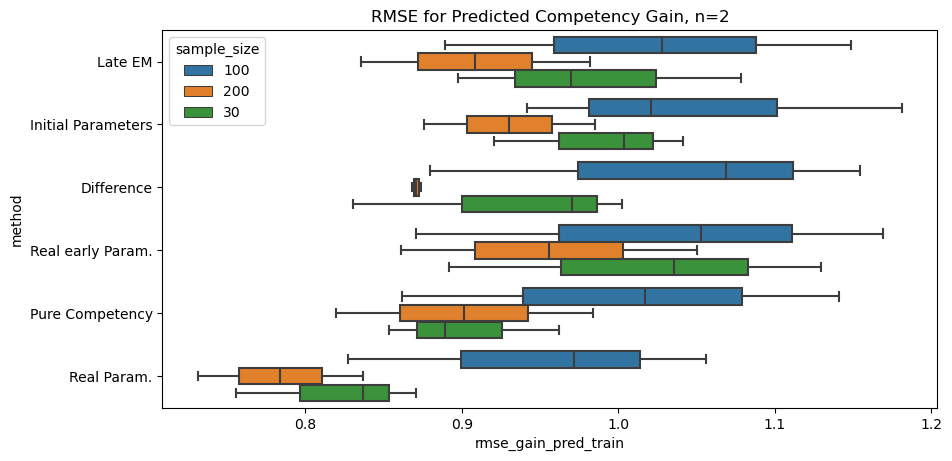

In [25]:
model_boxplot(full_Q_df, metric="rmse_gain_pred_train", title="RMSE for Predicted Competency Gain",
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_predicted.png", bbox_inches="tight")

### CSEDM Data
base: uirt_lfa_model_csedm_final.ipynb

In [26]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [27]:
semester = 'F19'
BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [28]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

In [29]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [30]:
V.shape

(367, 20)

In [31]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [32]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]

In [33]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.4044]
 [0.4044 1.    ]]
Step: 2: current parameter_diff: 7.291179527172233, current marginal loglikelihood: -5618.647896664741
EM Iteration 3
Current Monte Carlo Sample size: 300
[[1.     0.3166]
 [0.3166 1.    ]]
Step: 3: current parameter_diff: 3.7225723508498363, current marginal loglikelihood: -5608.540451734756
EM Iteration 4
Current Monte Carlo Sample size: 300
[[0.9999 0.2647]
 [0.2647 0.9999]]
Step: 4: current parameter_diff: 2.647591704499762, current marginal loglikelihood: -5592.725245320151
EM Iteration 5


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[0.9999 0.2688]
 [0.2688 1.    ]]
Step: 5: current parameter_diff: 1.385698317295841, current marginal loglikelihood: -5593.4492562841415
EM Iteration 6
Current Monte Carlo Sample size: 324
[[1.     0.2338]
 [0.2338 1.    ]]
Step: 6: current parameter_diff: 1.9128060105384799, current marginal loglikelihood: -5586.940920659123
EM Iteration 7
Current Monte Carlo Sample size: 349
[[1.     0.2563]
 [0.2563 0.9999]]
Step: 7: current parameter_diff: 0.5205668819087325, current marginal loglikelihood: -5584.632448511162
EM Iteration 8
Current Monte Carlo Sample size: 376
[[1.     0.2635]
 [0.2635 1.    ]]
Step: 8: current parameter_diff: 1.727449668969668, current marginal loglikelihood: -5586.788598168227
EM Iteration 9
Current Monte Carlo Sample size: 406
[[1.     0.2424]
 [0.2424 0.9999]]
Step: 9: current parameter_diff: 1.4240857783098242, current marginal loglikelihood: -5581.384353555039


In [34]:
# Estimate the Late Variance


In [35]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=np.ones(2),
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    logit=True, sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.01, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2
Current Monte Carlo Sample size: 300
[[ 1.      0.2424 -0.1983 -0.2456]
 [ 0.2424  0.9999 -0.2478 -0.1917]
 [-0.1983 -0.2478  0.6511  0.3276]
 [-0.2456 -0.1917  0.3276  0.6397]]
Step: 2: current parameter_diff: 13.182346411020225, current marginal loglikelihood: -4366.86993126403
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[ 1.      0.2424 -0.1581 -0.2488]
 [ 0.2424  0.9999 -0.2345 -0.158 ]
 [-0.1581 -0.2345  0.6933  0.3615]
 [-0.2488 -0.158   0.3615  0.687 ]]
Step: 3: current parameter_diff: 10.09386425407526, current marginal loglikelihood: -4329.191744994684
EM Iteration 4


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[ 1.      0.2424 -0.1499 -0.2419]
 [ 0.2424  0.9999 -0.2174 -0.1534]
 [-0.1499 -0.2174  0.6885  0.3409]
 [-0.2419 -0.1534  0.3409  0.6798]]
Step: 4: current parameter_diff: 5.4656022298911, current marginal loglikelihood: -4282.878828595035
EM Iteration 5


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[ 1.      0.2424 -0.1623 -0.247 ]
 [ 0.2424  0.9999 -0.2436 -0.1609]
 [-0.1623 -0.2436  0.6936  0.3429]
 [-0.247  -0.1609  0.3429  0.692 ]]
Step: 5: current parameter_diff: 3.1346570332824104, current marginal loglikelihood: -4258.516436414066
EM Iteration 6


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[ 1.      0.2424 -0.1539 -0.2501]
 [ 0.2424  0.9999 -0.2262 -0.162 ]
 [-0.1539 -0.2262  0.6846  0.3474]
 [-0.2501 -0.162   0.3474  0.6926]]
Step: 6: current parameter_diff: 2.3849649930821637, current marginal loglikelihood: -4257.602959394992
EM Iteration 7


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 406
[[ 1.      0.2424 -0.153  -0.243 ]
 [ 0.2424  0.9999 -0.2289 -0.1611]
 [-0.153  -0.2289  0.6828  0.3529]
 [-0.243  -0.1611  0.3529  0.6876]]
Step: 7: current parameter_diff: 2.795921914579703, current marginal loglikelihood: -4242.701513973824


### Item Parameters

In [36]:
#Item Parameters 

# Early 
early_A = early_model.item_parameters["discrimination_matrix"]
early_delta = early_model.item_parameters["intercept_vector"]
early_Q = early_model.item_parameters["q_matrix"]

# Late
late_A = late_model.item_parameters["discrimination_matrix"]
late_delta = late_model.item_parameters["intercept_vector"]
late_Q = late_model.item_parameters["q_matrix"]

In [37]:
shift = -1*np.quantile(s_hat, q=0.25, axis=0)
s_hat_shift = s_hat + shift
mu_shift = late_model.person_parameters["mean"][2:4] + shift
late_delta_shift = late_delta - np.dot(late_A, shift)

In [38]:
def item_parameter_table(A, Q, delta, latent_description=["Logic", "Iteration"], caption="", n=367):
    data = pd.DataFrame(np.concatenate((Q, A), axis=1))
    data.columns = pd.MultiIndex.from_product([['Q', 'A'], latent_description],
                                     names=['Param.', 'Latent dim.'])
    delta_df = pd.DataFrame(np.expand_dims(delta, 1), columns=[("$\Delta$", "")])
    data = pd.concat((data, delta_df), axis=1)
    data = np.round(data, 3)
    print(data.to_latex(bold_rows=True, multicolumn=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(data)

In [39]:
item_parameter_table(A=early_A, Q=early_Q, delta=early_delta, caption="CSEDM: Early Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Early Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   1.0 &       0.0 &  0.834 &     0.000 &    1.659 \\
\textbf{1 } &   1.0 &       0.0 &  1.210 &     0.000 &    1.276 \\
\textbf{2 } &   1.0 &       0.0 &  0.912 &     0.000 &    1.271 \\
\textbf{3 } &   1.0 &       0.0 &  0.777 &     0.000 &    1.307 \\
\textbf{4 } &   1.0 &       0.0 &  1.235 &     0.000 &    1.285 \\
\textbf{5 } &   1.0 &       0.0 &  1.517 &     0.000 &    1.517 \\
\textbf{6 } &   1.0 &       0.0 &  0.996 &     0.000 &    1.166 \\
\textbf{7 } &   1.0 &       0.0 &  0.800 &     0.000 &    1.305 \\
\textbf{8 } &   1.0 &       0.0 &  0.997 &     0.000 &    1.178 \\
\textbf{9 } &   1.0 &       0.0 &  1.376 &     0.000 &    1.200 \\
\textbf{10} &   1.0 &       0.0 &  1.173 &     0.00

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             1.0       0.0  0.834     0.000    1.659
1             1.0       0.0  1.210     0.000    1.276
2             1.0       0.0  0.912     0.000    1.271
3             1.0       0.0  0.777     0.000    1.307
4             1.0       0.0  1.235     0.000    1.285
5             1.0       0.0  1.517     0.000    1.517
6             1.0       0.0  0.996     0.000    1.166
7             1.0       0.0  0.800     0.000    1.305
8             1.0       0.0  0.997     0.000    1.178
9             1.0       0.0  1.376     0.000    1.200
10            1.0       0.0  1.173     0.000    1.427
11            1.0       0.0  1.174     0.000    1.588
12            1.0       0.0  1.145     0.000    1.484
13            1.0       0.0  1.316     0.000    1.484
14            1.0       0.0  1.004     0.000    1.167
15            1.0       0.0  1.097     0.000    0.773
16            1.0       0.0  1.162     0.000    1.262
17            1.0       0.0  1.123     0.000    1.142
18            1.0       1.0  1.176     0.674    0.282
19            1.0       0.0  0.835     0.000    0.656
20            0.0       1.0  0.000     2.249    1.439
21            1.0       1.0  0.067     2.879    1.346
22            1.0       1.0  0.307     1.551    0.991
23            1.0       1.0  0.450     1.625    1.001
24            1.0       1.0  1.124     1.251    1.525
25            1.0       0.0  0.875     0.000    1.096
26            1.0       1.0  0.535     1.284    0.517
27            1.0       1.0  0.905     1.295    1.212
28            1.0       1.0  0.727     0.754    0.888
29            1.0       1.0  0.692     1.505    0.965

In [40]:
item_parameter_table(A=late_A, Q=late_Q, delta=late_delta_shift, caption="CSEDM: Late Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Late Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   0.0 &       1.0 &  0.000 &     0.345 &    1.211 \\
\textbf{1 } &   1.0 &       1.0 &  0.972 &     0.718 &    1.013 \\
\textbf{2 } &   1.0 &       1.0 &  1.293 &     0.108 &    1.896 \\
\textbf{3 } &   1.0 &       1.0 &  0.856 &     1.412 &    0.745 \\
\textbf{4 } &   1.0 &       1.0 &  1.233 &     0.591 &    0.857 \\
\textbf{5 } &   1.0 &       1.0 &  0.716 &     0.548 &    0.839 \\
\textbf{6 } &   1.0 &       1.0 &  0.853 &     0.706 &    0.555 \\
\textbf{7 } &   1.0 &       1.0 &  0.190 &     1.145 &    0.834 \\
\textbf{8 } &   1.0 &       1.0 &  0.733 &     1.991 &    0.717 \\
\textbf{9 } &   1.0 &       1.0 &  0.116 &     1.113 &    0.143 \\
\textbf{10} &   1.0 &       1.0 &  0.849 &     0.935

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             0.0       1.0  0.000     0.345    1.211
1             1.0       1.0  0.972     0.718    1.013
2             1.0       1.0  1.293     0.108    1.896
3             1.0       1.0  0.856     1.412    0.745
4             1.0       1.0  1.233     0.591    0.857
5             1.0       1.0  0.716     0.548    0.839
6             1.0       1.0  0.853     0.706    0.555
7             1.0       1.0  0.190     1.145    0.834
8             1.0       1.0  0.733     1.991    0.717
9             1.0       1.0  0.116     1.113    0.143
10            1.0       1.0  0.849     0.935    0.688
11            1.0       1.0  0.327     1.872    1.155
12            1.0       1.0  0.341     1.266    0.829
13            1.0       1.0  0.432     0.974    0.930
14            0.0       1.0  0.000     1.073    1.572
15            1.0       1.0  0.056     1.762    1.047
16            1.0       1.0  0.280     1.617    0.257
17            1.0       1.0  0.474     1.038    0.657
18            0.0       1.0  0.000     1.551    0.983
19            0.0       1.0  0.000     1.452    1.148

(array([[  1.,   5.,  20.,  57.,  83., 121.,  64.,  15.,   1.,   0.],
        [  2.,   5.,  29.,  47.,  72.,  73.,  93.,  32.,  11.,   3.]]),
 array([-1.66390287, -1.26021727, -0.85653167, -0.45284608, -0.04916048,
         0.35452512,  0.75821071,  1.16189631,  1.56558191,  1.9692675 ,
         2.3729531 ]),
 <a list of 2 BarContainer objects>)

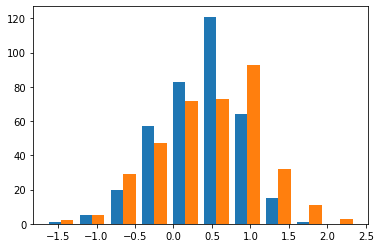

In [42]:
plt.hist(s_hat_shift)

### Person Parameters

In [43]:
#early
early_covariance = early_model.person_parameters["covariance"]
early_mu = np.zeros(2)

#late
late_covariance = late_model.person_parameters["covariance"]
late_mu = np.concatenate((early_mu, mu_shift), axis=0)

In [44]:
def table_person_parameters(covariance, mu, latent_description=["Logic", "Iteration"], caption="", n=367):
    cov_df = pd.DataFrame(covariance)
    index = pd.MultiIndex.from_product([['Prior Competence', 'Competence Gain'], latent_description],
                        names=['Param.', 'Latent dim.'])
    cov_df.columns = index
    mu_df = pd.DataFrame(np.expand_dims(mu, axis=1), columns=[("Mean", "")])
    person_df = pd.concat((cov_df, mu_df), axis=1)
    person_df.index = index
    person_df = np.round(person_df, 3)
    print(person_df.to_latex(bold_rows=True, multicolumn=True, 
                                caption=caption+", n={0}".format(n), 
                                position="H", escape=False))
    return(person_df)
    

In [46]:
table_person_parameters(covariance=late_covariance, mu=late_mu, caption="CSEDM: Person Parameters")
# TODO: Evtl. Korrelationsmatrix mit Varianz-Spalte

\begin{table}[H]
\centering
\caption{CSEDM: Person Parameters, n=367}
\begin{tabular}{llrrrrr}
\toprule
                & \textbf{Param.} & \multicolumn{2}{l}{Prior Competence} & \multicolumn{2}{l}{Competence Gain} &   Mean \\
                & \textbf{Latent dim.} &            Logic & Iteration &           Logic & \multicolumn{2}{l}{Iteration} \\
\textbf{Param.} & \textbf{Latent dim.} &                  &           &                 &           &        \\
\midrule
\textbf{Prior Competence} & \textbf{Logic} &            1.000 &     0.242 &          -0.153 &    -0.243 &  0.000 \\
                & \textbf{Iteration} &            0.242 &     1.000 &          -0.229 &    -0.161 &  0.000 \\
\textbf{Competence Gain} & \textbf{Logic} &           -0.153 &    -0.229 &           0.683 &     0.353 &  0.596 \\
                & \textbf{Iteration} &           -0.243 &    -0.161 &           0.353 &     0.688 &  0.764 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1204287124.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(person_df.to_latex(bold_rows=True, multicolumn=True,


Param.                       Prior Competence           Competence Gain  \
Latent dim.                             Logic Iteration           Logic   
Param.           Latent dim.                                              
Prior Competence Logic                  1.000     0.242          -0.153   
                 Iteration              0.242     1.000          -0.229   
Competence Gain  Logic                 -0.153    -0.229           0.683   
                 Iteration             -0.243    -0.161           0.353   

Param.                                   Mean  
Latent dim.                  Iteration         
Param.           Latent dim.                   
Prior Competence Logic          -0.243  0.000  
                 Iteration      -0.161  0.000  
Competence Gain  Logic           0.353  0.596  
                 Iteration       0.688  0.764

# Gain Visualization

In [103]:
def quantile_mean(df, metric, quantiles=[0.25, 0.5, 0.75, 1]):
    mean_df = pd.DataFrame()
    metric_quantiles = np.quantile(df[metric], quantiles)
    for quantile in metric_quantiles:
        quantile_df = df[df[metric] < quantile]
        df = df[df[metric] >= quantile]
        mean_df = pd.concat((mean_df, pd.DataFrame(quantile_df.mean()).transpose()), axis=0)
    mean_df.index = quantiles
    return(mean_df)

In [104]:
latent_df_csedm = pd.DataFrame(np.concatenate((theta_hat, s_hat_shift), axis=1))
latent_df_csedm.columns = ["prior logic", "prior iter", "logic gain", "iter gain"]

In [109]:
logic_quantile_mean = quantile_mean(latent_df_csedm, metric="prior logic")
logic_quantile_mean["post logic"] = logic_quantile_mean["prior logic"] + logic_quantile_mean["logic gain"]
logic_quantile_mean["post iter"] = logic_quantile_mean["prior iter"] + logic_quantile_mean["iter gain"]
np.round(logic_quantile_mean, 2)

,prior logic,prior iter,logic gain,iter gain,post logic,post iter
0.25,-0.95,-0.19,0.44,0.57,-0.51,0.37
0.50,-0.20,-0.03,0.32,0.39,0.12,0.36
0.75,0.33,-0.02,0.34,0.43,0.67,0.41
1.00,1.11,0.42,0.30,0.46,1.41,0.88


In [55]:
logic_quantiles = np.quantile(theta_hat[:,0], [0.25, 0.5, 0.75, 1], axis=0)
iter_quantiles = np.quantile(theta_hat[:,1], [0.25, 0.5, 0.75, 1], axis=0)

In [79]:
theta_hat[np.argsort(theta_hat[:,0])]

array([[-2.51204267e+00, -8.08001251e-01],
       [-2.37179512e+00, -1.54247459e+00],
       [-2.26955198e+00, -1.54759463e+00],
       [-2.16089953e+00, -1.55394048e+00],
       [-1.98373826e+00, -8.13255289e-01],
       [-1.77844857e+00, -1.15340706e+00],
       [-1.77139918e+00, -1.58474829e+00],
       [-1.66832914e+00, -2.18772843e-01],
       [-1.55817274e+00, -3.43022961e-01],
       [-1.45810640e+00,  2.97300150e-01],
       [-1.39382200e+00, -2.77069105e-01],
       [-1.38220880e+00,  5.31400377e-01],
       [-1.30305617e+00,  1.05611246e+00],
       [-1.26041016e+00, -5.34166743e-01],
       [-1.25279671e+00,  6.84999148e-01],
       [-1.23679706e+00,  3.39353769e-01],
       [-1.23355152e+00,  4.31648326e-01],
       [-1.15782265e+00, -3.21743990e-01],
       [-1.15187778e+00, -6.36495204e-01],
       [-1.13649077e+00, -1.66421714e+00],
       [-1.13287064e+00, -1.04500014e+00],
       [-1.10070036e+00,  1.00232119e+00],
       [-1.08461889e+00,  1.41957558e-01],
       [-1.

In [84]:
theta_logic_quantiles = np.split(theta_hat[np.argsort(theta_hat[:,0]), :], [10, 20])

In [85]:
theta_logic_quantiles

[array([[-2.51204267, -0.80800125],
        [-2.37179512, -1.54247459],
        [-2.26955198, -1.54759463],
        [-2.16089953, -1.55394048],
        [-1.98373826, -0.81325529],
        [-1.77844857, -1.15340706],
        [-1.77139918, -1.58474829],
        [-1.66832914, -0.21877284],
        [-1.55817274, -0.34302296],
        [-1.4581064 ,  0.29730015]]),
 array([[-1.393822  , -0.27706911],
        [-1.3822088 ,  0.53140038],
        [-1.30305617,  1.05611246],
        [-1.26041016, -0.53416674],
        [-1.25279671,  0.68499915],
        [-1.23679706,  0.33935377],
        [-1.23355152,  0.43164833],
        [-1.15782265, -0.32174399],
        [-1.15187778, -0.6364952 ],
        [-1.13649077, -1.66421714]]),
 array([[-1.13287064e+00, -1.04500014e+00],
        [-1.10070036e+00,  1.00232119e+00],
        [-1.08461889e+00,  1.41957558e-01],
        [-1.08156741e+00, -1.64113799e-01],
        [-1.06010362e+00,  9.91778070e-01],
        [-1.05472344e+00, -4.86328275e-01],
        [-1.